## Test distortion compensation 

Projects targets to focal plane and applies distortion compensation.
Displays mean and std deviation of errors in X and Y.

In [1]:
%matplotlib notebook

import sys
import logging
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append("../DesignTool")
from smdtLibs.configFile import ConfigFile
from targets import TargetList
from smdtLibs.inOutChecker import InOutChecker
from maskDesignFile import (
    MaskDesignInputFitsFile,
    MaskDesignOutputFitsFile,
    outputAsList,
)
from maskLayouts import MaskLayouts, GuiderFOVs, shrinkMask
from smdtLibs import utils, drawUtils, DARCalculator
from astropy.modeling import models, fitting

from DistortionUtil import *

from Test_InputM import Test_Inputs

In [2]:
try:
    %load_ext nb_black
except:
    print("Ignore extension nb_black")
    pass

<IPython.core.display.Javascript object>

In [3]:
logging.disable()

<IPython.core.display.Javascript object>

In [4]:
#
# Gets the configs data
#
config_fname = "../DesignTool/smdt.cfg"
param_fname = "../DesignTool/params.cfg"

config = ConfigFile(config_fname)
config.properties["params"] = ConfigFile(param_fname)

layout = MaskLayouts["deimos"]
guiderLayout = GuiderFOVs["deimos"]

<IPython.core.display.Javascript object>

In [5]:
def calcErrorRMS(x1, x2):
    dx = x1 - x2
    return np.mean(dx), np.std(dx)

def calcErrors(designInfo, applyDAR=False):
    """
    Given a designInfo (a test case), calculates the projection, applies the distortion compensation
    and calcualtes the mean and std deviation of the errors.
    
    Returns the MDF object, difference RMS X and difference RMS Y
    """
    mdf, tlist, calcX, calcY, targetX, targetY, slitsXYs = project(designInfo, config, layout, offx=-1.3, offy=178.5)
    # CalculatedX, calculatedY, DSIMx, DSIMy
    
    pxs, pys = applyDistortionCorrection(calcX, calcY, tlist)
    return mdf, calcErrorRMS(targetX, pxs), calcErrorRMS(targetY, pys)


<IPython.core.display.Javascript object>

In [6]:
Test_Inputs.keys()

dict_keys(['LeoIa', 'n2419c', 'denseOverlappingMask', 'denseNoOverlappingMask', 'denseOverlappingPa90Mask', 'denseNoOverlappingPa90Mask', 'denseNoOverlapPa270', 'denseNoOverlapPa180', 'NoOverlapPa180L4500', 'NoOverlapPa270L4500', 'NoOverlapPa90L4500'])

<IPython.core.display.Javascript object>

### For all test cases, calcualtes the mean and std deviation of the distortion compensation errors.

In [7]:
out = []

for k, item in Test_Inputs.items():
    (input_fname, input_RA, input_DEC, fieldPA, xxslitPA, enabled) = item
    if not enabled:
        continue
    mdf, xerr, yerr = calcErrors(item)
    waveLength = mdf.maskblu.RefWave[0]
    paDeg = mdf.maskdesign.PA_PNT[0]
    haDeg = mdf.maskdesign.LST_PNT[0]
    shortName = input_fname.split("/")[-1]

    out.append((shortName, waveLength, paDeg, haDeg, *xerr, *yerr))

df = pd.DataFrame(
    out,
    columns=(
        "Name",
        "Wavelength",
        "paDeg",
        "haDeg",
        "X_mean",
        "X_std",
        "Y_mean",
        "Y_std",
    ),
)
df

FileNotFoundError: [Errno 2] No such file or directory: '../DeimosExamples/experimentMasksShared/denseOverlappingMask.fits'

<IPython.core.display.Javascript object>

offsetx -0.0516876765708521


<IPython.core.display.Javascript object>


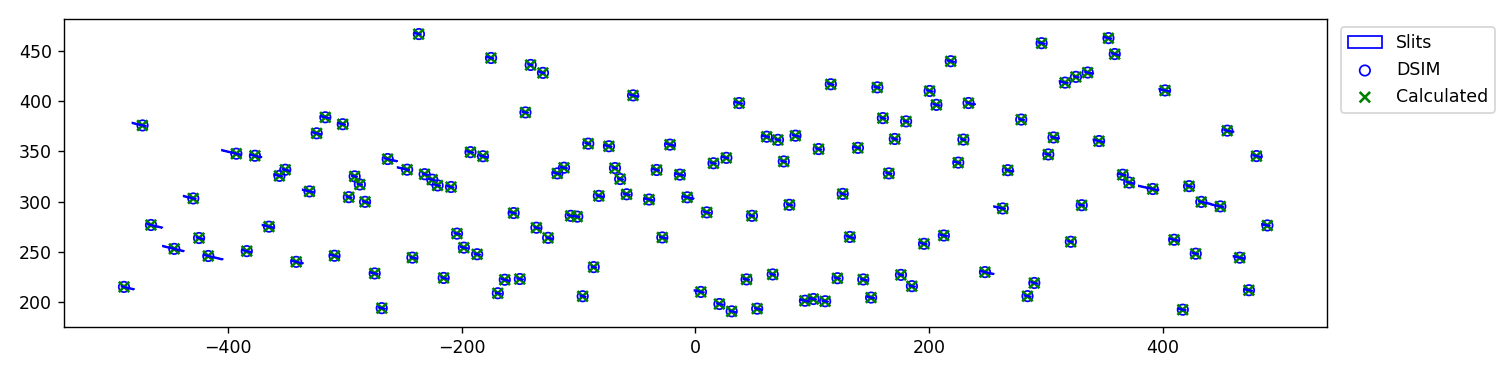

<IPython.core.display.Javascript object>

In [23]:
# 
# Test for one case, no DAR
#
maskInfo = Test_Inputs["LeoIa"]
maskInfo = list(maskInfo)
maskInfo[4] = 0

mdf, tlist, calcX, calcY, targetX, targetY, slitXYs = project(maskInfo, config, layout, offx=-1.4, offy=178.5)
pxs, pys = applyDistortionCorrection(calcX, calcY, tlist)

offx = np.mean(pxs - targetX)
print ("offsetx", offx)

plt.figure(figsize=(12, 3))
plt.scatter(targetX, targetY, fc="None", ec="b", marker='o', label="DSIM")
plt.scatter(pxs, pys, fc="None", ec="g", marker="x", label="Calculated")


p1 = drawUtils.drawPatch(plt.gca(), slitXYs, fc="None", ec="b")
p1.set_label ("Slits")

plt.legend(bbox_to_anchor=(1.14, 1))
plt.tight_layout()


In [24]:
def calcAR (mdf, tlist, config, haDeg):
    """
    Calculate DAR
    Returns DAR values, parallactic angles for each target
    """    
    
    latitudeDeg = config.getValue("telLatitude")
    params = config.params
    centerWaveLength = 450 # mdf.maskblu.RefWave[0]
    pressure = params.Pressure[0]
    temperature = params.Temperature[0]
    
    dar = DARCalculator.DARCalculator(latitudeDeg, centerWaveLength, pressure, temperature)
 
    print (f"Center wavelength {centerWaveLength:.2f} nm")
    return dar.calcAR(haDeg, tlist)


<IPython.core.display.Javascript object>

In [25]:
refARs, parangRads, elRads = calcAR(mdf, tlist, config, mdf.maskdesign.LST_PNT[0],)

Center wavelength 450.00 nm


<IPython.core.display.Javascript object>

In [26]:
(xerrs, xstd), (yerrs, ystd) = calcErrorRMS(targetX, pxs), calcErrorRMS(targetY, pys)
print(f"{xerrs=:.3f}, {yerrs=:.3f}")

print(targetX.shape, pxs.shape, refARs.shape, tlist.targets.shape)


xerrs=0.052, yerrs=0.063
(142,) (142,) (142,) (147, 39)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


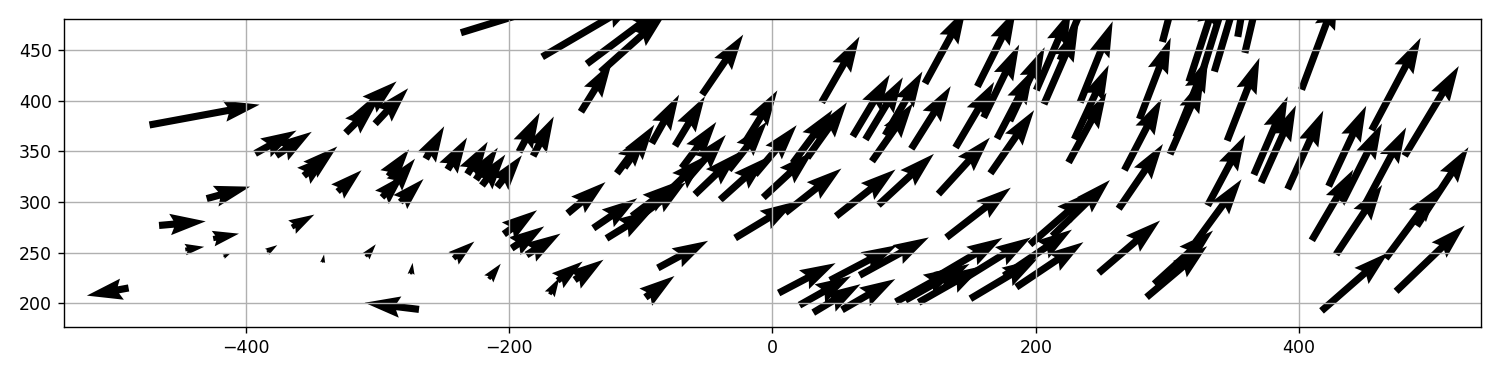

<IPython.core.display.Javascript object>

In [28]:
plt.figure(figsize=(12, 3))

drefx0 = refARs * np.cos(parangRads - elRads)
drefy0 = refARs * np.sin(parangRads - elRads)

drefx = drefx0 - np.mean(drefx0)
drefy = drefy0 - np.mean(drefy0)

dx = targetX - pxs
dy = targetY - pys

mode = "q"

if mode == "q":
    plt.gca().quiver(
        targetX,
        targetY,
        dx,
        dy,
        # scale=4,
        # scale_units="xy",
        # headwidth=0.3,
        # headlength=0.1,
    )
elif mode == "v":
    plt.plot(dx, ".", label="dx")
    plt.plot(dy, ".", label="dy")
    plt.legend()
elif mode == "d":
    plt.plot(dx, dy, ".")
    plt.xlim(-1.0, 1.0)
    plt.ylim(-1.0, 1.0)
elif mode == "x":
    plt.plot(dx, ".", label="dx")
    plt.plot(drefx, ".", label="refAR")
    plt.legend()
elif mode == "y":
    plt.plot(dy, ".", label="dy")
    plt.plot(drefy, ".", label="refAR")

    plt.legend()
plt.grid()
plt.tight_layout()

In [18]:
mdf.maskdesign

,DesId,DesName,DesAuth,DesCreat,DesDate,DesNslit,DesNobj,ProjName,INSTRUME,MaskType,RA_PNT,DEC_PNT,RADEPNT,EQUINPNT,PA_PNT,DATE_PNT,LST_PNT
0,1,dNoOver ...,syeh <syeh@keck.hawaii.edu> ...,Dsimulator: Ver 0.0b ...,2020-12-21T01:34:14,466,466,dra ...,DEIMOS ...,??? ...,259.735829,57.899353,,2000.0,90.0,2020-12-31,22.5


<IPython.core.display.Javascript object>

In [ ]:
t1 = tlist.targets[tlist.targets.pcode > 0]

In [ ]:
t0 = tlist.targets[tlist.targets.pcode > 0]
t1 = t0[np.abs(dx) > 0.5]

In [ ]:
for row in zip(t1.slitLen, t1.TopDist, t1.BotDist, t1.pcode):
    print(*row, f"{row[0] - row[1] - row[2]:.2f}, {row[0] + row[1] - row[2]:.2f}")